# Group Project Report - Prediction of User Knowledge 


## Introduction


Using the User Knowledge dataset, we will predict the level of student knowledge (UNS - Very Low, Low, Middle, or High)  regarding the topic of electrical DC machines, which are rotational electrical motors that change electrical energy into mechanical energy. We have 5 predictors to choose from: PEG (exam performance based on the topic), LPR (exam performance of prerequisite knowledge), STG (amount of study time), SCG (amount of practice done), and STR (prerequisite knowledge on relevant topics).


## Preliminary Exploratory Data Analysis

First, the necessary libraries to analyze our data are read.

In [93]:
library(tidyverse)
library(repr)
library(caret)
library(readxl)

### Reading Data into R

The data set is read into R by downloading the file from this [link](https://archive.ics.uci.edu/ml/machine-learning-databases/00257/Data_User_Modeling_Dataset_Hamdi%20Tolga%20KAHRAMAN.xls).It is then stored in the same folder as this file. The data set is already split into one for training and one for testing. 

In [94]:
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00257/Data_User_Modeling_Dataset_Hamdi%20Tolga%20KAHRAMAN.xls"

In [95]:
download.file(url, destfile="user_data")

In [96]:
training_data_raw <- read_excel("user_data", sheet = 2)
head(training_data_raw)

testing_data_raw <- read_excel("user_data", sheet = 3)
head(testing_data_raw)

New names:
* `` -> ...7
* `` -> ...8



STG,SCG,STR,LPR,PEG,UNS,...7,...8,Attribute Information:
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<lgl>,<lgl>,<chr>
0.00,0.00,0.00,0.00,0.00,very_low,NA,NA,"STG (The degree of study time for goal object materails),"
0.08,0.08,0.10,0.24,0.90,High,NA,NA,SCG (The degree of repetition number of user for goal object materails)
0.06,0.06,0.05,0.25,0.33,Low,NA,NA,STR (The degree of study time of user for related objects with goal object)
0.10,0.10,0.15,0.65,0.30,Middle,NA,NA,LPR (The exam performance of user for related objects with goal object)
0.08,0.08,0.08,0.98,0.24,Low,NA,NA,PEG (The exam performance of user for goal objects)
0.09,0.15,0.40,0.10,0.66,Middle,NA,NA,UNS (The knowledge level of user)


New names:
* `` -> ...7
* `` -> ...8



STG,SCG,STR,LPR,PEG,UNS,...7,...8,Attribute Information:
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<lgl>,<lgl>,<chr>
0.00,0.10,0.50,0.26,0.05,Very Low,NA,NA,"STG (The degree of study time for goal object materails),"
0.05,0.05,0.55,0.60,0.14,Low,NA,NA,SCG (The degree of repetition number of user for goal object materails)
0.08,0.18,0.63,0.60,0.85,High,NA,NA,STR (The degree of study time of user for related objects with goal object)
0.20,0.20,0.68,0.67,0.85,High,NA,NA,LPR (The exam performance of user for related objects with goal object)
0.22,0.22,0.90,0.30,0.90,High,NA,NA,PEG (The exam performance of user for goal objects)
0.14,0.14,0.70,0.50,0.30,Low,NA,NA,UNS (The knowledge level of user)


Three extra columns were read that do not contain data from the data set. Thus, they have been selected out. In addition, it seems that the variables do not need to be scaled because each is on the same scale from 0 to 1.

In [97]:
training_data <- select(training_data_raw, STG, SCG, STR, LPR, PEG, UNS)
head(training_data)

testing_data <- select(testing_data_raw, STG, SCG, STR, LPR, PEG, UNS)
head(testing_data)

STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.00,0.00,0.00,0.00,0.00,very_low
0.08,0.08,0.10,0.24,0.90,High
0.06,0.06,0.05,0.25,0.33,Low
0.10,0.10,0.15,0.65,0.30,Middle
0.08,0.08,0.08,0.98,0.24,Low
0.09,0.15,0.40,0.10,0.66,Middle


STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.00,0.10,0.50,0.26,0.05,Very Low
0.05,0.05,0.55,0.60,0.14,Low
0.08,0.18,0.63,0.60,0.85,High
0.20,0.20,0.68,0.67,0.85,High
0.22,0.22,0.90,0.30,0.90,High
0.14,0.14,0.70,0.50,0.30,Low


We change the classifer to a factor type which is useful for later analysis.

In [98]:
training_data <- training_data %>%
        mutate(UNS = as.factor(UNS))

testing_data <- testing_data %>%
        mutate(UNS = as.factor(UNS))

### Summarizating of Training Data Set

The code below checks to see if there are any missing rows in any of the training data.

In [99]:
anyNA(training_data)

[1] FALSE

None are found! The training data set is complete.

Now, we will find the number of observations in each class in training set.

In [100]:
number_of_rows_training <- training_data %>%
        group_by(UNS) %>%
        summarize(n = n())
number_of_rows_training

UNS,n
<fct>,<int>
High,63
Low,83
Middle,88
very_low,24


The number of observations are similar for three of the four classes. The "very low" class has very few observations. Thus, oversampling may be needed for the "very low" class.

The code below finds the mean value of each predictor for each category.

In [101]:
mean_value_training <- training_data %>%
        group_by(UNS) %>%
        summarize(mean_STG = mean(STG), mean_PEG = mean(PEG), mean_LPR = mean(LPR), mean_SCG = mean(SCG), mean_STR = mean(STR))

mean_value_training

UNS,mean_STG,mean_PEG,mean_LPR,mean_SCG,mean_STR
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
High,0.4216508,0.77253968,0.5012698,0.4231905,0.5016667
Low,0.3211446,0.23762651,0.4973494,0.3370000,0.4307229
Middle,0.3999773,0.54238636,0.3428409,0.3679205,0.5068182
very_low,0.3057917,0.09083333,0.3587500,0.1981250,0.3662500


Looking at the table, PEG has the highest variance in mean among the different classifiers. Thus, it is the variable that will be the best predictor. The other 4 variables are harder to decipher based solely on this table, so they will be looked at closely in the visualization of data.

### Prelimary Data Exploration & Visualization

The correlations between the 5 predictor variables are visualized.

Warning message in ggcorr(training_data, method = c("everything", "pearson")):
“data in column(s) 'UNS' are not numeric and were ignored”


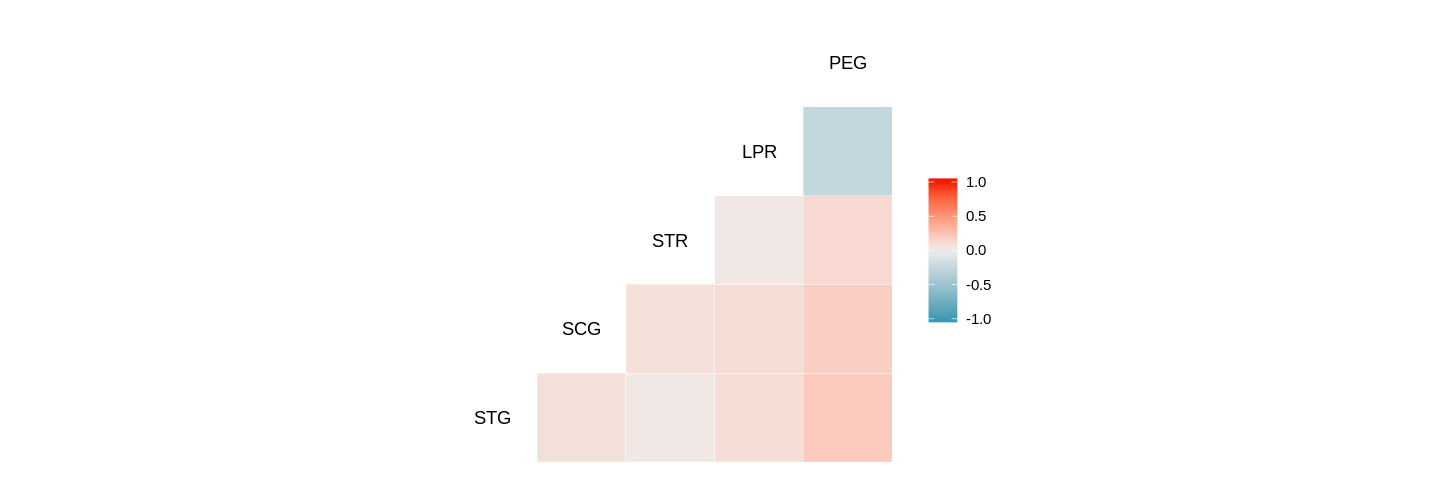

In [102]:
options(repr.plot.height = 4)
library(GGally)

ggcorr(training_data, method = c("everything", "pearson"))

Plotting the correlation matrix between the predictor variables shows low correlations between each of the 5 predictors, so multicollinearity issues are unlikely to be a consideration in feature selection.

Then, the function ggpairs is used to compare the distributions and values of each predictor.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



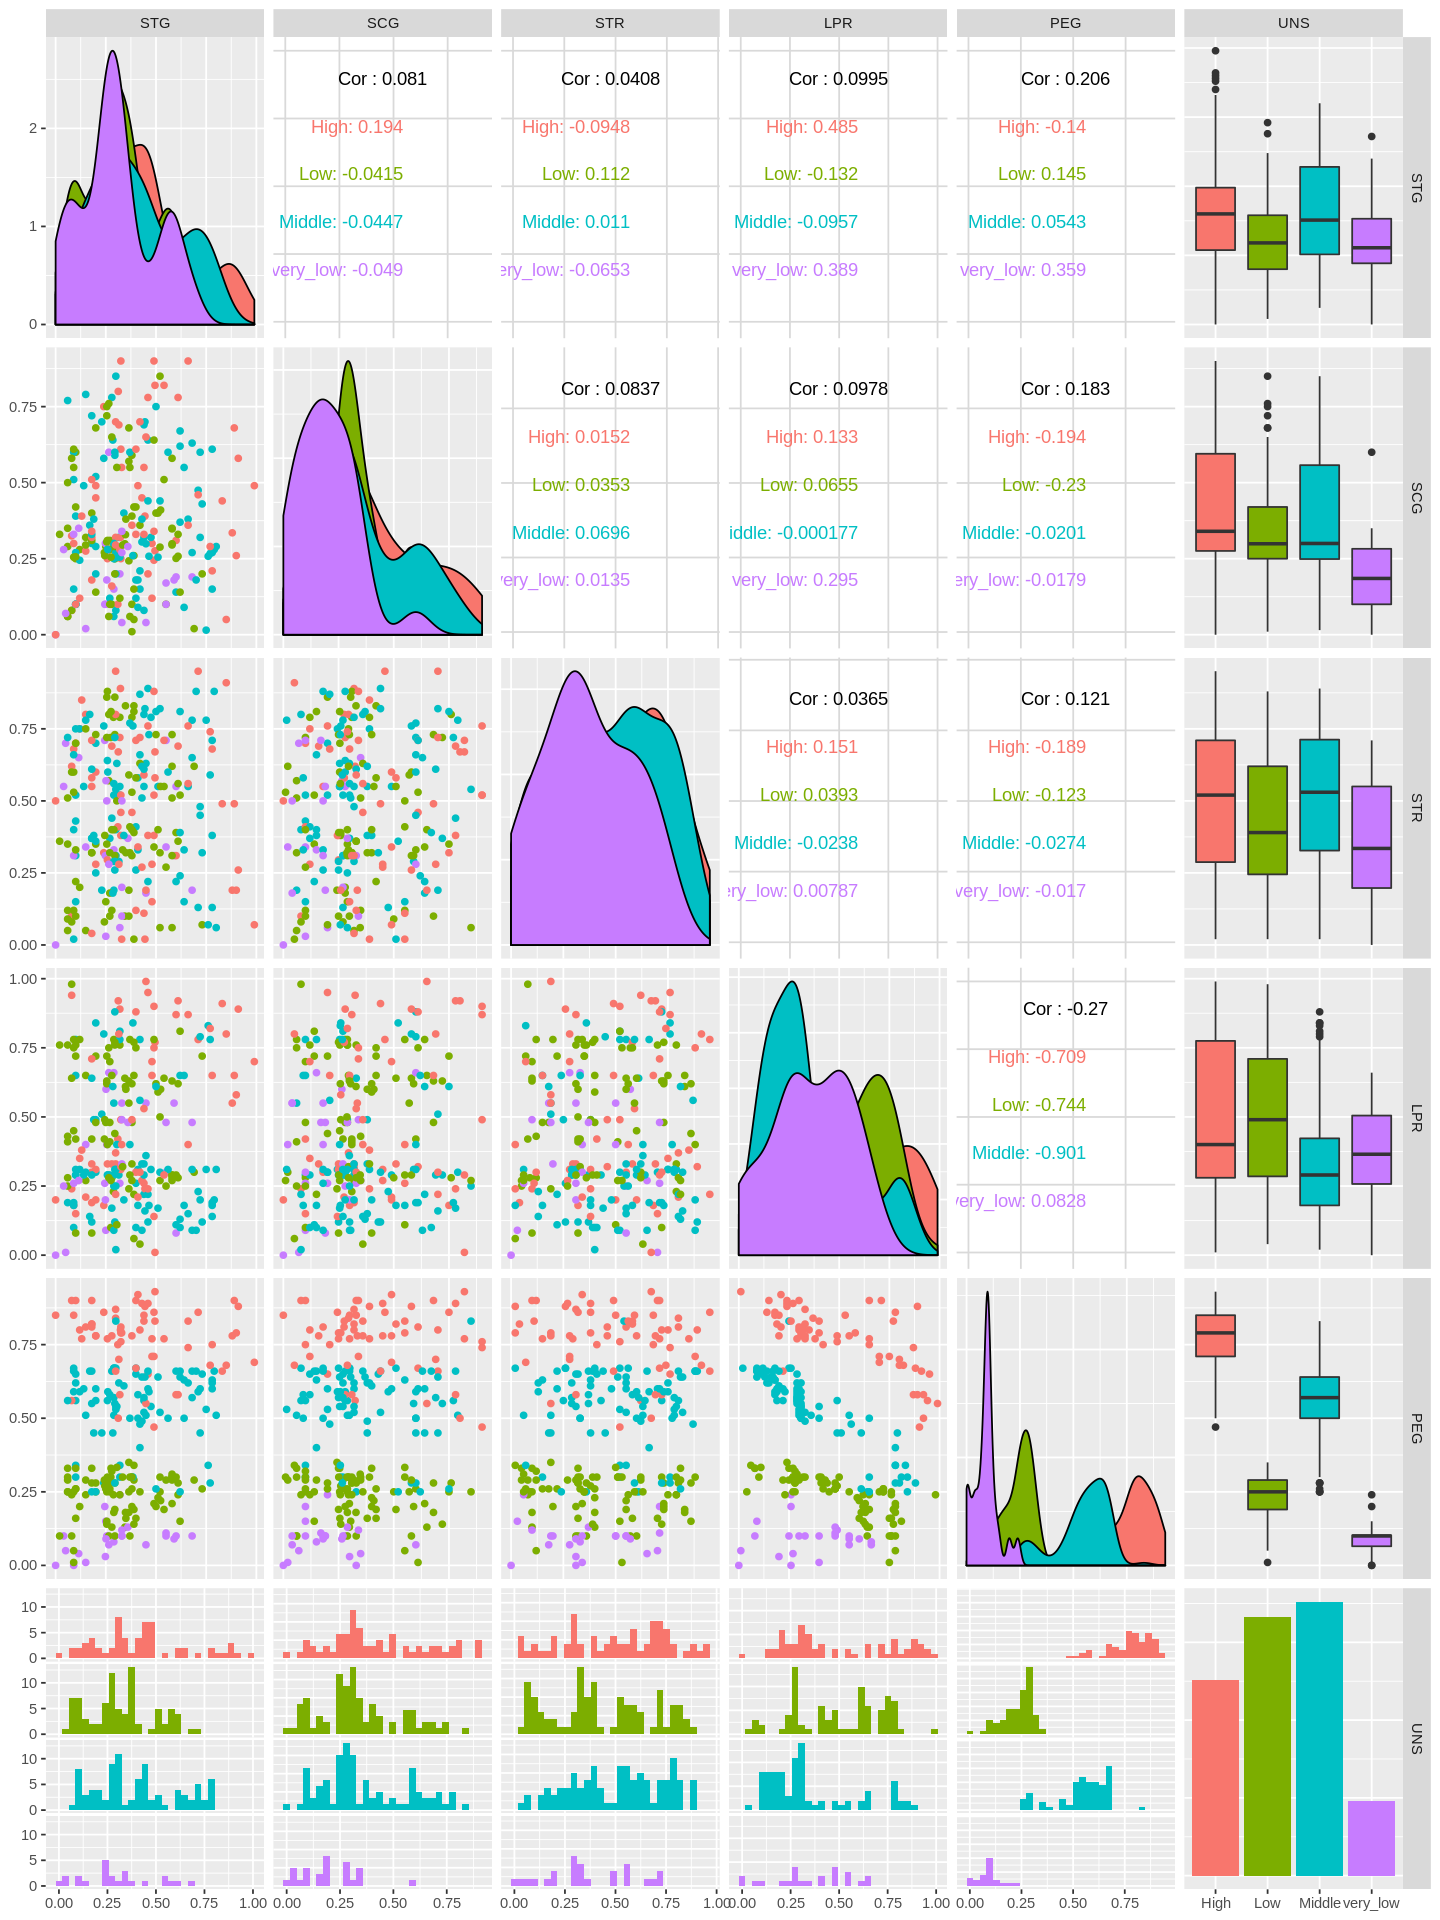

In [103]:
options(repr.plot.height = 16, repr.plot.width = 12)
ggpairs(training_data, columns = 1:6, ggplot2::aes(colour=UNS))

The ggpairs visualization  establishes that the distributions of each UNS category are most differentiated in relation to PEG, relative to the other variables. The filled area plots of PEG for each UNS category reveals that the “High” class takes standardized PEG values between 0.4 and 1 while users in the "Very Low" class appear to only possess PEG scores between the standardized values of 0.00 to 0.25 in the filled area plot. 

Since the distributions of PEG values vary greatly across the UNS levels, PEG is likely to be a good predictor of UNS levels and should therefore be included in the model. 

Two other variables that also show noticeable variation in distribution for different levels of UNS (albeit to a lesser degree) are STG and LPR.

## Classification

In [104]:
# use supervised learning - knn classification
head(training_data)

STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.00,0.00,0.00,0.00,0.00,very_low
0.08,0.08,0.10,0.24,0.90,High
0.06,0.06,0.05,0.25,0.33,Low
0.10,0.10,0.15,0.65,0.30,Middle
0.08,0.08,0.08,0.98,0.24,Low
0.09,0.15,0.40,0.10,0.66,Middle


In [146]:
head(testing_data)

STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.00,0.10,0.50,0.26,0.05,Very Low
0.05,0.05,0.55,0.60,0.14,Low
0.08,0.18,0.63,0.60,0.85,High
0.20,0.20,0.68,0.67,0.85,High
0.22,0.22,0.90,0.30,0.90,High
0.14,0.14,0.70,0.50,0.30,Low


In [147]:
# testing and training data have different labels in UNS column: very_low vs Very Low 
# we need to clean training data

In [179]:
# cleaning training data to change all rows with very_low to Very Low

# use new dataframe - do not change old 
training_data_clean <- training_data

# chanmge UNS to character
training_data_clean$UNS = as.character(training_data_clean$UNS)

# change very_low to Very Low
training_data_clean[training_data_clean$UNS == "very_low", "UNS"] <- "Very Low"

# change UNS back to factor 
training_data_clean$UNS = as.factor(training_data_clean$UNS)

# training_data
head(training_data_clean)


STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.00,0.00,0.00,0.00,0.00,Very Low
0.08,0.08,0.10,0.24,0.90,High
0.06,0.06,0.05,0.25,0.33,Low
0.10,0.10,0.15,0.65,0.30,Middle
0.08,0.08,0.08,0.98,0.24,Low
0.09,0.15,0.40,0.10,0.66,Middle


In [180]:
# run knn with PEG, STG and LPR 

# get training data 
X_train <- training_data_clean %>%
select(PEG, STG, LPR) %>%
data.frame()

Y_train <- training_data_clean %>%
select(UNS) %>%
unlist()

glimpse(X_train)

head(Y_train)

Observations: 258
Variables: 3
$ PEG <dbl> 0.00, 0.90, 0.33, 0.30, 0.24, 0.66, 0.56, 0.01, 0.25, 0.85, 0.81,…
$ STG <dbl> 0.00, 0.08, 0.06, 0.10, 0.08, 0.09, 0.10, 0.15, 0.20, 0.00, 0.18,…
$ LPR <dbl> 0.00, 0.24, 0.25, 0.65, 0.98, 0.10, 0.29, 0.40, 0.72, 0.20, 0.30,…


UNS1     UNS2     UNS3     UNS4     UNS5     UNS6 
Very Low     High      Low   Middle      Low   Middle 
Levels: High Low Middle Very Low

In [181]:
# get testing data 
X_test<- testing_data %>%
select(PEG, STG, LPR) %>%
data.frame()

Y_test <- testing_data %>%
select(UNS) %>%
unlist()

glimpse(X_test)

head(Y_test)

Observations: 145
Variables: 3
$ PEG <dbl> 0.05, 0.14, 0.85, 0.85, 0.90, 0.30, 0.50, 0.15, 0.80, 0.07, 0.66,…
$ STG <dbl> 0.00, 0.05, 0.08, 0.20, 0.22, 0.14, 0.16, 0.12, 0.20, 0.16, 0.11,…
$ LPR <dbl> 0.26, 0.60, 0.60, 0.67, 0.30, 0.50, 0.50, 0.68, 0.77, 0.10, 0.05,…


UNS1     UNS2     UNS3     UNS4     UNS5     UNS6 
Very Low      Low     High     High     High      Low 
Levels: High Low Middle Very Low

In [182]:
# try k from 1 to 30, by increments of 1 

k_ls <- data.frame(k = seq(from = 1, to = 30, by = 1))

head(k_ls)

,k
,<dbl>
1,1
2,2
3,3
4,4
5,5
6,6


In [183]:
# use 5 - fold cross validation 

train_control <- trainControl(method="cv", number = 5)

In [184]:
# train model 
user_knn_model <- train(x = X_train, 
                        y = Y_train, 
                        method = "knn", 
                        tuneGrid = k_ls, 
                        trControl = train_control)

user_knn_model

k-Nearest Neighbors 

258 samples
  3 predictor
  4 classes: 'High', 'Low', 'Middle', 'Very Low' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 209, 205, 207, 206, 205 
Resampling results across tuning parameters:

  k   Accuracy   Kappa    
   1  0.9111109  0.8742329
   2  0.9111230  0.8740282
   3  0.9228151  0.8903640
   4  0.9069567  0.8683338
   5  0.9225042  0.8899422
   6  0.8950170  0.8503126
   7  0.9226494  0.8897401
   8  0.8954097  0.8505750
   9  0.8761761  0.8226851
  10  0.8760132  0.8227460
  11  0.8760886  0.8227218
  12  0.8682455  0.8109593
  13  0.8605503  0.7999219
  14  0.8604657  0.7996137
  15  0.8606257  0.7997153
  16  0.8647074  0.8054936
  17  0.8567767  0.7945385
  18  0.8565441  0.7940345
  19  0.8488489  0.7826377
  20  0.8450782  0.7766070
  21  0.8296758  0.7537858
  22  0.8338300  0.7603145
  23  0.8259022  0.7481445
  24  0.8182071  0.7369521
  25  0.8103519  0.7251029
  26  0.8103519  0.7248785
  27  0.8141254  0.7

In [185]:
testing_accuracies <- user_knn_model$results

head(testing_accuracies)

,k,Accuracy,Kappa,AccuracySD,KappaSD
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,0.9111109,0.8742329,0.03692617,0.05355633
2,2,0.9111230,0.8740282,0.05000948,0.07152588
3,3,0.9228151,0.8903640,0.05408849,0.07783631
4,4,0.9069567,0.8683338,0.04578671,0.06619596
5,5,0.9225042,0.8899422,0.03575342,0.05140089
6,6,0.8950170,0.8503126,0.02353483,0.03366036


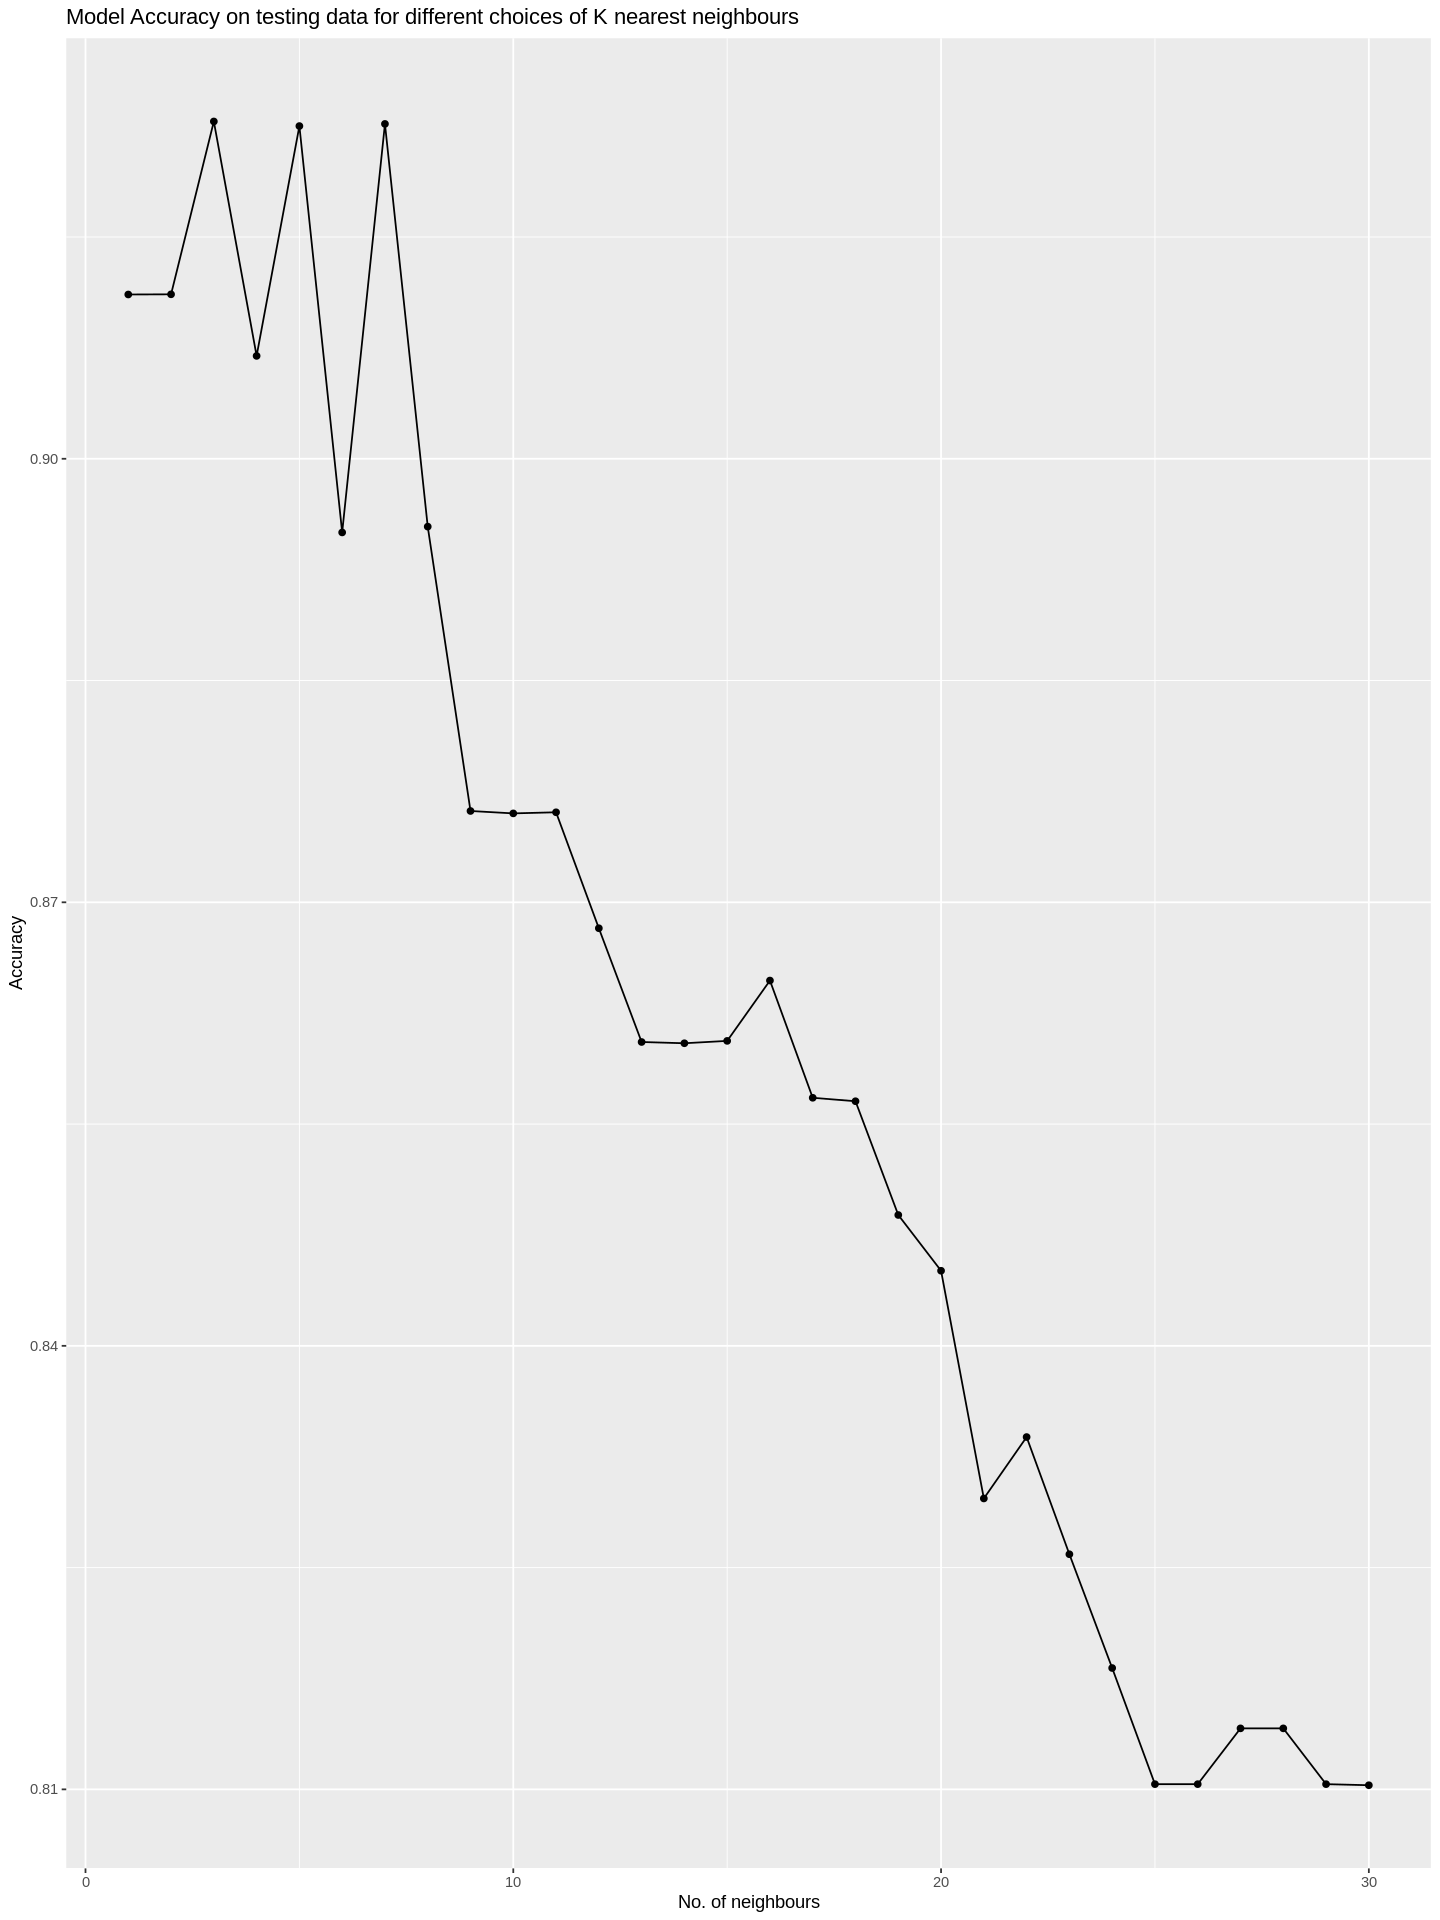

In [186]:
# k = 3 is best model 

# plot accuracy on testing data 

testing_accuracy_plot <- testing_accuracies %>%
ggplot(aes(x = k, y = Accuracy)) + 
geom_point() + 
geom_line() + 
labs(x = "No. of neighbours", y = "Accuracy") + 
ggtitle("Model Accuracy on testing data for different choices of K nearest neighbours")

testing_accuracy_plot

In [197]:
# k = 3 gives highest accuracy 

# use k = 3 for final model 
k_best <- data.frame(k = 3)

#train using k = 3 
model_k_3 <- train(x = X_train, y = Y_train, method = "knn", tuneGrid = k_best, trControl = train_control)

model_k_3

k-Nearest Neighbors 

258 samples
  3 predictor
  4 classes: 'High', 'Low', 'Middle', 'Very Low' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 207, 207, 205, 207, 206 
Resampling results:

  Accuracy   Kappa    
  0.9182418  0.8843854

Tuning parameter 'k' was held constant at a value of 3

In [200]:
# get accuracy on testing data 

# predict labels on testing set 
test_predictions <- predict(object = model_k_3, X_test)
# test_predictions 

# Y_test

# compute the accuracy 
model_quality <- confusionMatrix(data = test_predictions, reference = Y_test)
model_quality 

Confusion Matrix and Statistics

          Reference
Prediction High Low Middle Very Low
  High       39   0      1        0
  Low         0  45      3        3
  Middle      0   1     30        0
  Very Low    0   0      0       23

Overall Statistics
                                          
               Accuracy : 0.9448          
                 95% CI : (0.8942, 0.9759)
    No Information Rate : 0.3172          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.925           
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: High Class: Low Class: Middle Class: Very Low
Sensitivity               1.0000     0.9783        0.8824          0.8846
Specificity               0.9906     0.9394        0.9910          1.0000
Pos Pred Value            0.9750     0.8824        0.9677          1.0000
Neg Pred Value            1.0000     0.98

In [216]:
# plot against actual labels -> UNS on x axis, each factor on y axis, coloured by prediction
all_predictions <- data.frame(Y_test, data.frame(test_predictions), X_test)
head(all_predictions)

,Y_test,test_predictions,PEG,STG,LPR
,<fct>,<fct>,<dbl>,<dbl>,<dbl>
UNS1,Very Low,Very Low,0.05,0.00,0.26
UNS2,Low,Low,0.14,0.05,0.60
UNS3,High,High,0.85,0.08,0.60
UNS4,High,High,0.85,0.20,0.67
UNS5,High,High,0.90,0.22,0.30
UNS6,Low,Low,0.30,0.14,0.50


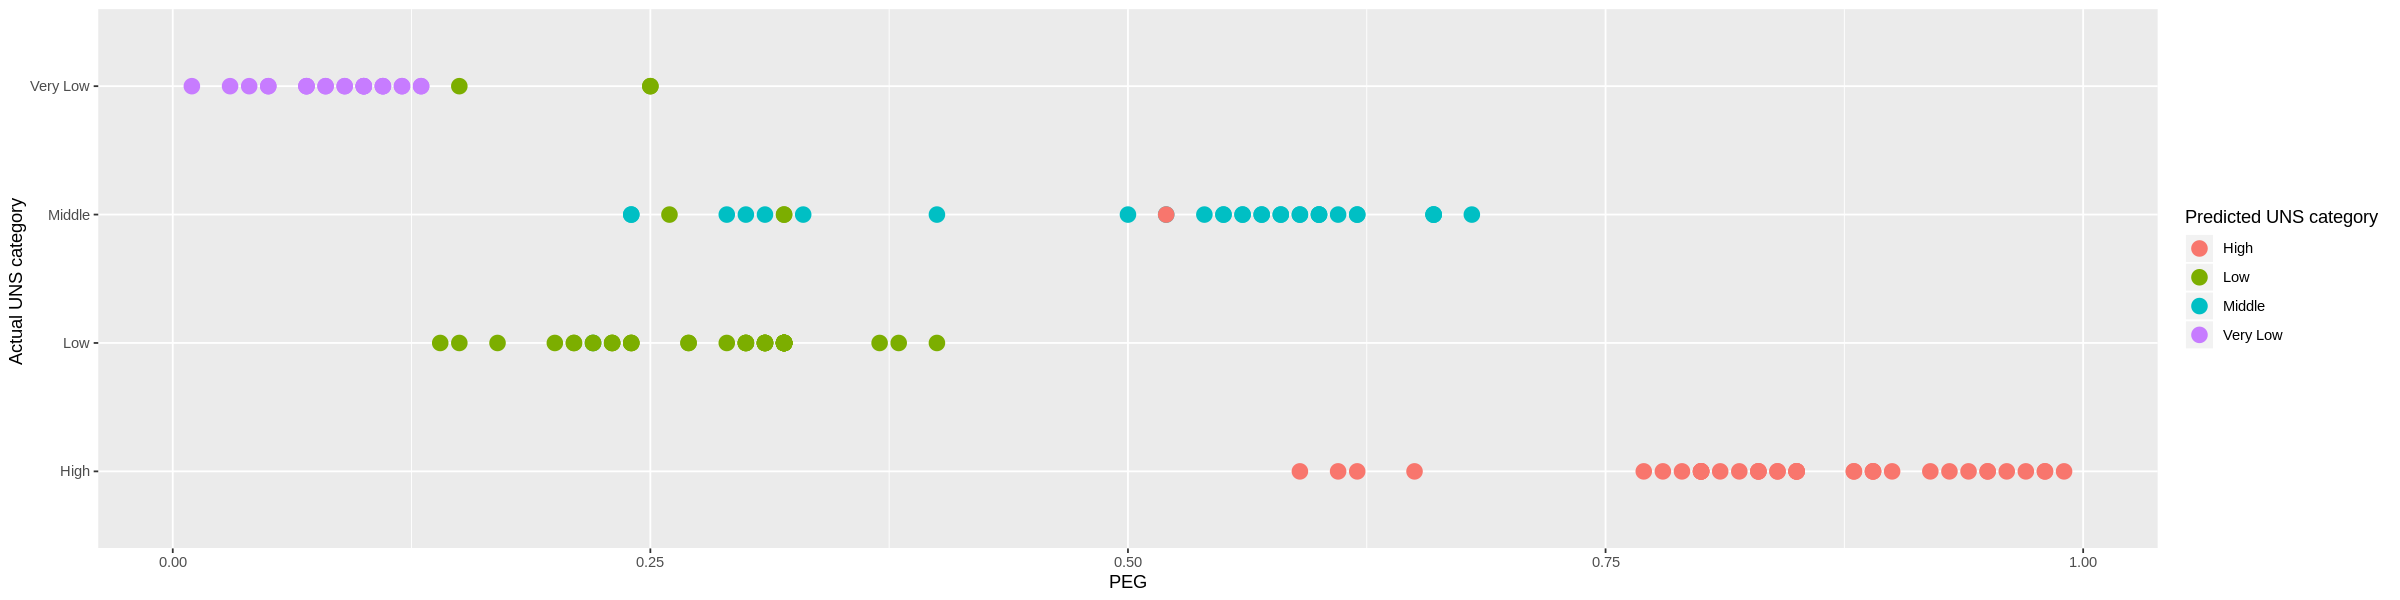

In [236]:
options(repr.plot.height = 5, repr.plot.width = 20)
predictions_plot_peg <- all_predictions %>%
ggplot(aes(x = Y_test, y = PEG, colour = test_predictions)) +
geom_point(size = 4) + 
labs(x = "Actual UNS category ", y = "PEG", colour = "Predicted UNS category") + 
coord_flip()


predictions_plot_peg

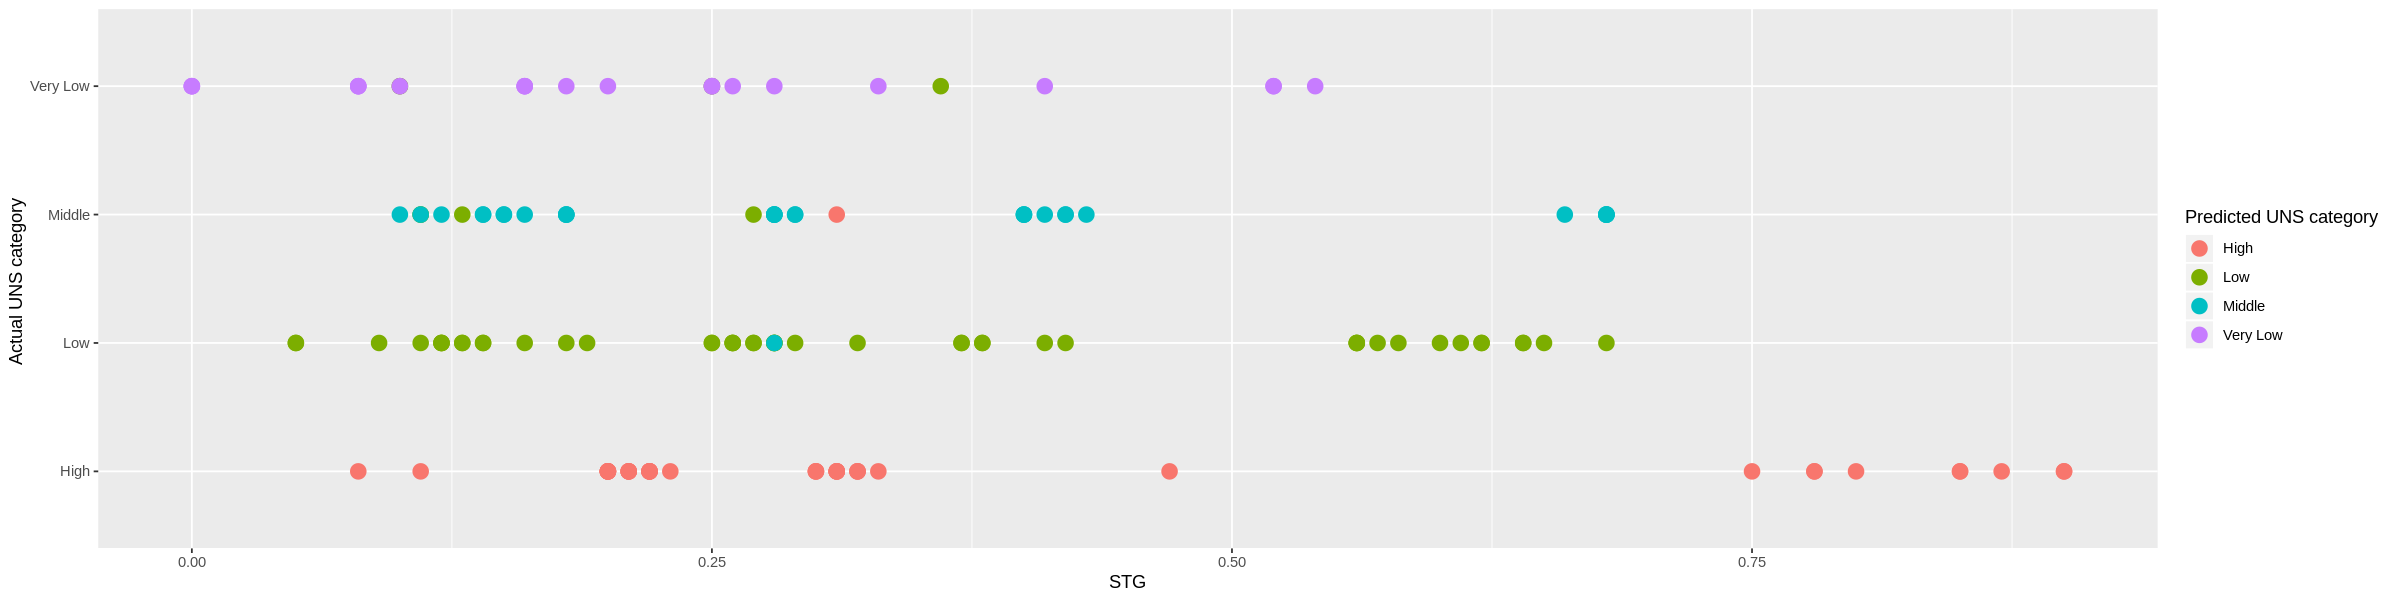

In [238]:
options(repr.plot.height = 5, repr.plot.width = 20)
predictions_plot_stg <- all_predictions %>%
ggplot(aes(x = Y_test, y = STG, colour = test_predictions)) +
geom_point(size = 4) + 
labs(x = "Actual UNS category ", y = "STG", colour = "Predicted UNS category")+ 
coord_flip()

predictions_plot_stg

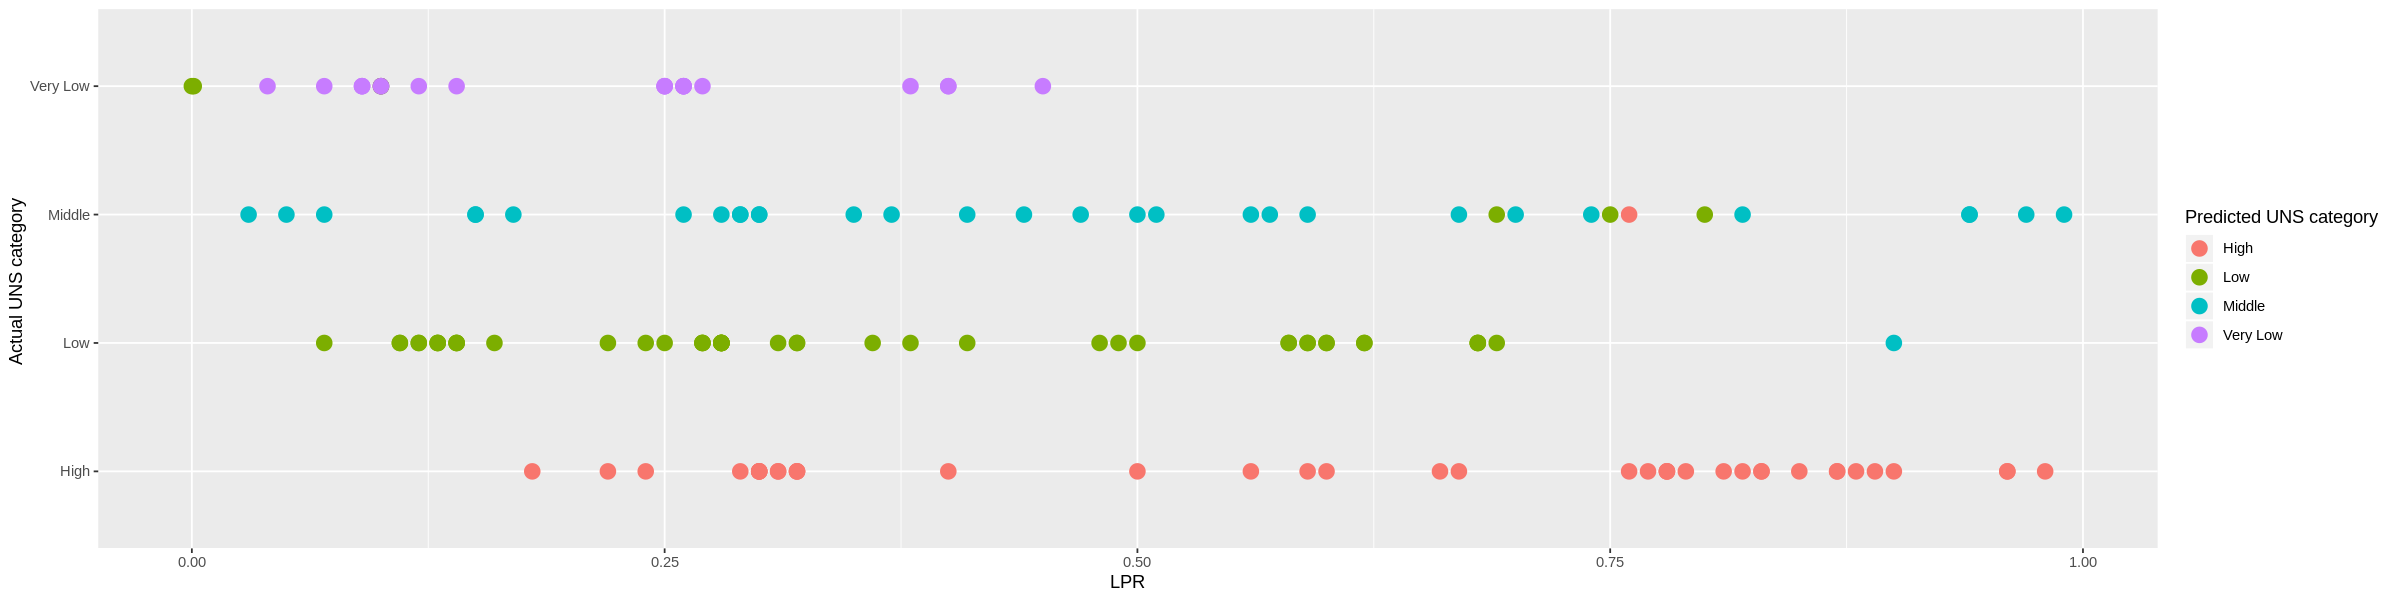

In [237]:
options(repr.plot.height = 5, repr.plot.width = 20)
predictions_plot_lpr <- all_predictions %>%
ggplot(aes(x = Y_test, y = LPR, colour = test_predictions)) +
geom_point(size = 4) + 
labs(x = "Actual UNS category ", y = "LPR", colour = "Predicted UNS category")+ 
coord_flip()

predictions_plot_lpr

In [1]:
## discussion

## Methods

Little data wrangling is required for our project on the User Knowledge dataset as it is in a format that can already be used for k-nn classification. We will be using three predictors (STG, LPR and PEG) and their values in our KNN model. These predictors were chosen due to the more distinctive difference in their mean values which assures that the data for different UNS classes are not clustering around the same range. To analyse our dataset, we will use scatterplot graphs to convey the overall picture. A data frame with four columns will be used: STG, LPR, PEG, and the knowledge level of users. Three pairs of scatter plot graphs will be made to compare the classification of values made by our model versus the true classes of the values. Each scatter plot pair will plot a unique pair of the three predictors that are being used while the classes of the values will be used to color the points, one scatter plot having the predicted classes while the other the true classes. The resulting scatter plot will have predictors on both axes and points colored by the predicted labels and also the true labels (UNS). 


## Expected Outcomes and Significance

We expect to build a classifier that can quite accurately predict the knowledge level of users based on the predictors. Such findings could make an impact by allowing institutions (i.e. schools and businesses) to manipulate data from other disciplines or fields to identify individuals with lower levels of knowledge. This could lead to future questions relating to whether the trajectory or progress of users with lower levels of knowledge can be traced to understand the most optimal procedures to increase their knowledge level. 
